In [539]:
import numpy as np
import seaborn as sns
import pandas as pd 
import matplotlib.pyplot as plt

import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.utils.data as data
import torch.nn.functional as F

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, recall_score, accuracy_score, confusion_matrix, classification_report

from torch.utils.data import Dataset




In [540]:
torch.cuda.is_available()

True

In [541]:
channels = ['Fp1',
 'F7',
 'F8',
 'T4',
 'T6',
 'T5',
 'T3',
 'Fp2',
 'O1',
 'P3',
 'Pz',
 'F3',
 'Fz',
 'F4',
 'C4',
 'P4',
 'POz',
 'C3',
 'Cz',
 'O2']

In [683]:
df = pd.read_pickle('corr_dataset_5_sec.pkl')

df.head()

,UID,Condition,Correlation
0,9003_RSEC_0,HC,"[[1.0, 0.96546376, 0.7910419, 0.2598703, -0.15..."
1,9003_RSEC_1,HC,"[[1.0, 0.6407249, 0.30460477, 0.37413487, 0.10..."
2,9003_RSEC_2,HC,"[[1.0, 0.89586425, 0.7257316, 0.5698556, 0.535..."
3,9003_RSEC_3,HC,"[[0.99999994, 0.8080953, 0.59378445, 0.4633816..."
4,9003_RSEC_4,HC,"[[1.0, 0.83913195, 0.69550496, 0.39472985, 0.4..."


In [684]:
g = df.groupby('Condition')
df_usampling = g.apply(lambda x: x.sample(g.size().min())).reset_index(drop=True)

df_usampling

,UID,Condition,Correlation
0,9231_RSEC_53,AD,"[[0.99999994, 0.703518, -0.39568585, -0.295428..."
1,9247_RSEC_20,AD,"[[1.0, 0.9874051, 0.96325874, 0.92418003, 0.84..."
2,9261_RSEO_14,AD,"[[1.0, 0.3866337, 0.58966273, 0.4832381, 0.405..."
3,9232_RSEO_33,AD,"[[1.0, 0.8244427, 0.6557878, 0.48287788, 0.258..."
4,9232_RSEC_35,AD,"[[1.0, 0.5821282, 0.14841738, 0.16742873, -0.0..."
...,...,...,...
6235,9106_RSEC_44,HC,"[[0.99999994, 0.6927726, 0.52820206, 0.5550254..."
6236,9607_RSEO_33,HC,"[[0.99999994, 0.8971207, 0.8026089, 0.45570043..."
6237,9632_RSEC_15,HC,"[[1.0, 0.30773893, 0.2970209, 0.17685196, 0.13..."
6238,9605_RSEO_8,HC,"[[1.0, 0.818728, 0.6801741, 0.4498436, 0.28939..."


In [685]:
X = np.stack(df_usampling["Correlation"].ravel())
X.shape

(6240, 20, 20)

c:\Users\jimmy\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


<AxesSubplot:xlabel='Condition', ylabel='count'>

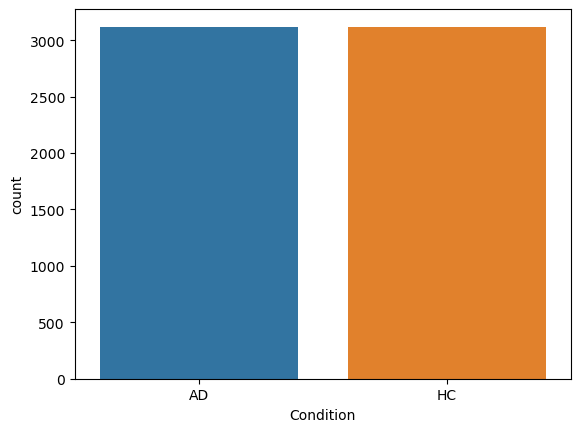

In [686]:
sns.countplot(df_usampling["Condition"])

In [687]:
# Binary enconding 
Y = df_usampling["Condition"].to_numpy()

l_encoder = LabelEncoder()
i_encoded = l_encoder.fit_transform(Y)
print(i_encoded)

Y = i_encoded.reshape(1, -1).T

[0 0 0 ... 1 1 1]


In [547]:
# Onehot enconding 
o_encoder = OneHotEncoder(sparse=False)
i_encoded = i_encoded.reshape(len(i_encoded), 1)
o_encoded = o_encoder.fit_transform(i_encoded)
print(o_encoded)

#Y = o_encoded

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [574]:
Y = Y.T

In [549]:
X = Variable(torch.from_numpy(X.astype(np.float32)), requires_grad=False)
Y = Variable(torch.from_numpy(Y.astype(np.float32)), requires_grad=False)

In [672]:
X_train, X_test, y_train, y_test = train_test_split(   
     X, Y, test_size=0.2, random_state=42)

#X_train, X_val, y_train, y_val = train_test_split(   
#     X_train, y_train, test_size=0.1, random_state=42)

In [551]:
tags_train = l_encoder.inverse_transform(y_train)
tags_test = l_encoder.inverse_transform(y_test)

c:\Users\jimmy\Anaconda3\lib\site-packages\sklearn\preprocessing\_label.py:154: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


IndexError: arrays used as indices must be of integer (or boolean) type

c:\Users\jimmy\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
c:\Users\jimmy\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


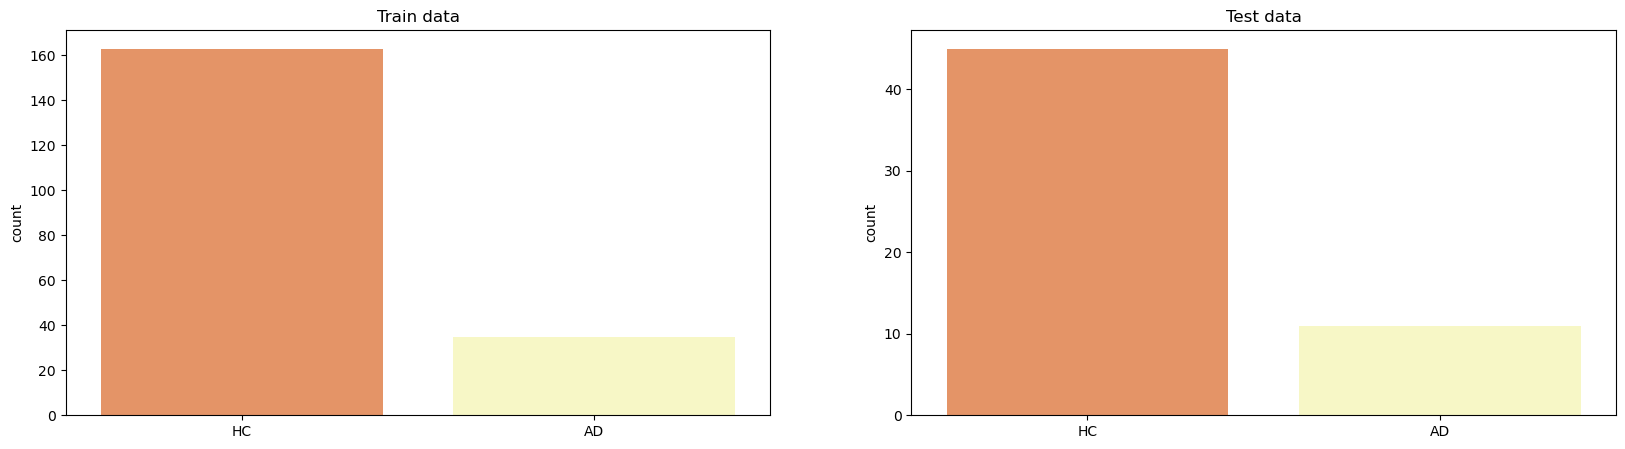

In [616]:
colors = sns.color_palette('Spectral', 3)
palette = {mode: color for mode, color in zip(["HC", "AD", "MCI"], colors)}

fig, ax = plt.subplots(1,2,figsize=(20,5))


sns.countplot(tags_train, ax=ax[0], palette=palette)
ax[0].set_title("Train data")

sns.countplot(tags_test, ax=ax[1], palette=palette);
ax[1].set_title("Test data");

In [ ]:
data_dist = {"train" : len(X_train), "test" : len(X_test), "val" : len(X_val)}
data_dist

{'train': 220, 'test': 56, 'val': 22}

In [ ]:
from torchsummary import summary

In [ ]:
# Network Initialization 

model = nn.Sequential(
          nn.Conv2d(1,16,3),
          nn.Conv2d(16,16,3),
          nn.MaxPool2d(2),
          nn.Dropout(),
          nn.Conv2d(16,32,3),
          nn.Conv2d(32,32,3),
          nn.MaxPool2d(3),
          nn.Dropout(),
          nn.Flatten(start_dim=0),
          nn.Linear(32, 160),
          nn.ReLU(),
          nn.Linear(160, 1),
          nn.Softmax(0)
        )
model.to("cuda")

#summary(model, (1,20,20))

Sequential(
  (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1))
  (1): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1))
  (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (3): Dropout(p=0.5, inplace=False)
  (4): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1))
  (5): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1))
  (6): MaxPool2d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
  (7): Dropout(p=0.5, inplace=False)
  (8): Flatten(start_dim=0, end_dim=-1)
  (9): Linear(in_features=32, out_features=160, bias=True)
  (10): ReLU()
  (11): Linear(in_features=160, out_features=1, bias=True)
  (12): Softmax(dim=0)
)

In [ ]:
train_ds = torch.utils.data.TensorDataset(X_train, y_train)
validation_ds = torch.utils.data.TensorDataset(X_test, y_test)


train_ds_loader = torch.utils.data.DataLoader(train_ds,shuffle=True)
val_ds_loader = torch.utils.data.DataLoader(validation_ds,shuffle=True)

In [576]:
import torch.optim as optim


loss_fn=nn.BCEWithLogitsLoss()
optimizer=optim.SGD(model.parameters(),lr=0.1,momentum=0.9)

AttributeError: 'GridSearchCV' object has no attribute 'parameters'

In [ ]:
def accuracy(predictions, labels):
    classes = torch.argmax(predictions, dim=0)
    #print(classes)
    return torch.mean((classes == labels).float())

In [ ]:
num_epoch = 30 
train_losses=[]
valid_losses=[]

for epoch in range(1,num_epoch+1):
  train_loss=0.0
  valid_loss=0.0
a
  train_f1 =0.0
  train_acc = 0.0

  model.train()
  for img,lbl in train_ds_loader:
    img=img.cuda()
    lbl=lbl.cuda()
    #img=img.cpu()
    #lbl=lbl.cpu()

    optimizer.zero_grad()
    predict=model(img)
    loss=loss_fn(predict,lbl.flatten())
    loss.backward()
    optimizer.step()

    train_loss+=loss.item()*img.size(0)

    label = lbl.flatten().cpu()
    prediction = predict.cpu().detach().numpy()
    print((label, prediction))
    train_acc += accuracy_score(label, prediction)
    train_f1 += f1_score(label, prediction)

  model.eval()
  for img,lbl in val_ds_loader:
    img=img.cuda()
    lbl=lbl.cuda()
    #img=img.cpu()
    #lbl=lbl.cpu()

    predict=model(img)
    loss=loss_fn(predict,lbl.flatten())

    valid_loss+=loss.item()*img.size(0)

  train_loss=train_loss/len(train_ds_loader.sampler) 
  valid_loss=valid_loss/len(val_ds_loader.sampler)

  train_acc=train_acc/train_f1
  
  train_f1=train_f1/len(val_ds_loader.sampler)
  train_losses.append(train_loss)
  valid_losses.append(valid_loss)

  print('Epoch:{} Train Loss:{:.4f} valid Losss:{:.4f} Train Accuracy:{:.4f} Train F1:{:.4f}'.format(epoch,train_loss,valid_loss, train_acc, train_f1))    

In [688]:
X_train_reshape = X_train.reshape(X_train.shape[0],400)
X_test_reshape = X_test.reshape(X_test.shape[0],400)

In [689]:
np.sum(np.isnan(X_train_reshape))

0

In [690]:
from sklearn.svm import SVC  
from sklearn.model_selection import GridSearchCV

param_grid = {'C': [0.1,1, 10, 100], 'gamma': [1,0.1,0.01,0.001],'kernel': ['rbf', 'poly', 'sigmoid']}

grid = GridSearchCV(SVC(),param_grid,refit=True)
grid.fit(X_train_reshape,y_train)

c:\Users\jimmy\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jimmy\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jimmy\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jimmy\Anaconda3\lib\site-packages\sklearn\utils\validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), 

GridSearchCV(estimator=SVC(),
             param_grid={'C': [0.1, 1, 10, 100], 'gamma': [1, 0.1, 0.01, 0.001],
                         'kernel': ['rbf', 'poly', 'sigmoid']})

In [691]:
print(grid.best_estimator_)

SVC(C=100, gamma=0.1)


In [702]:
grid.estimator.get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

0.8533653846153846


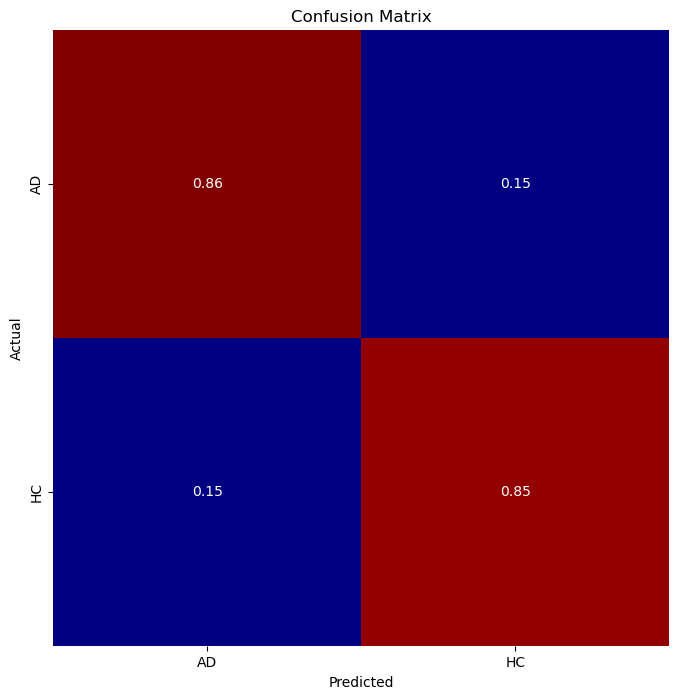

              precision    recall  f1-score   support

           0       0.86      0.86      0.86       213
           1       0.85      0.85      0.85       203

    accuracy                           0.85       416
   macro avg       0.85      0.85      0.85       416
weighted avg       0.85      0.85      0.85       416



In [712]:
y_pred=grid.predict(X_test_reshape)


print(accuracy_score(y_test, y_pred))

class_report = showClassficationReport(y_pred , y_test.T[0])
print(class_report)


In [600]:
y_pred

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,
       1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1,
       1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1,
       1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0])

In [587]:
labels = set(df["Condition"])
labels = ['AD', 'HC']

In [588]:
tick_labels = labels
n_classes = len(labels)
def showClassficationReport(y_pred, y_true, top_n = 1):
    # Loop on each generator batch and predict

    conf_matrix = confusion_matrix(y_true, y_pred, labels=np.arange(n_classes))

    conf_matrix = conf_matrix/np.sum(conf_matrix, axis=1)
    fig, ax = plt.subplots(figsize=(8,8))
    sns.heatmap(conf_matrix, annot=True, fmt=".2f", square=True, cbar=False, 
                cmap=plt.cm.jet, xticklabels=tick_labels, yticklabels=tick_labels,
                ax=ax)
    ax.set_ylabel('Actual')
    ax.set_xlabel('Predicted')
    ax.set_title('Confusion Matrix')
    plt.show()
 
    class_report = classification_report(y_true, y_pred)
    return class_report

In [592]:
# Random forest 

from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(max_depth=2, random_state=0)
clf.fit(X_train_reshape,y_train)



y_pred = clf.predict(X_test_reshape)

accuracy_score(y_test, y_pred)

C:\Users\jimmy\AppData\Local\Temp\ipykernel_5264\1228826906.py:5: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  clf.fit(X_train_reshape,y_train)


0.7971014492753623

In [693]:
from sklearn.neural_network import MLPClassifier

parameter_space = {
    'hidden_layer_sizes': [(128,128,64)],
    'activation': ['relu'],
    'solver': ['lbfgs',],
    'alpha': [0.0001],
    'learning_rate': ['adaptive'],
    'learning_rate_init' : [ 0.01]}

clf = GridSearchCV(MLPClassifier(), parameter_space, n_jobs=-1, cv=5)
clf.fit(X_train_reshape, y_train) # X is train samples and y is the corresponding labels


c:\Users\jimmy\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:1109: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
c:\Users\jimmy\Anaconda3\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


GridSearchCV(cv=5, estimator=MLPClassifier(), n_jobs=-1,
             param_grid={'activation': ['relu'], 'alpha': [0.0001],
                         'hidden_layer_sizes': [(128, 128, 64)],
                         'learning_rate': ['adaptive'],
                         'learning_rate_init': [0.01], 'solver': ['lbfgs']})

0.8197115384615384


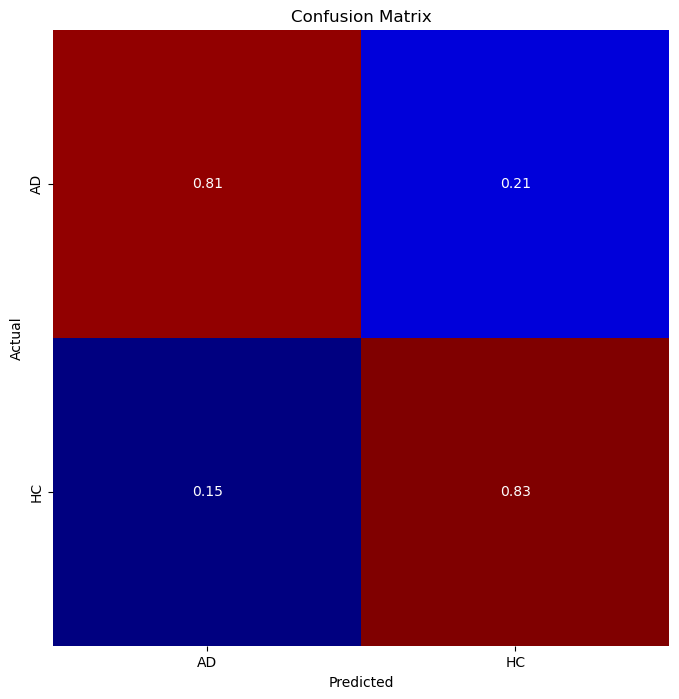

              precision    recall  f1-score   support

           0       0.84      0.81      0.83       220
           1       0.80      0.83      0.81       196

    accuracy                           0.82       416
   macro avg       0.82      0.82      0.82       416
weighted avg       0.82      0.82      0.82       416



In [694]:
y_pred = clf.predict(X_test_reshape)

print(accuracy_score(y_test, y_pred))
print(showClassficationReport(y_test, y_pred))


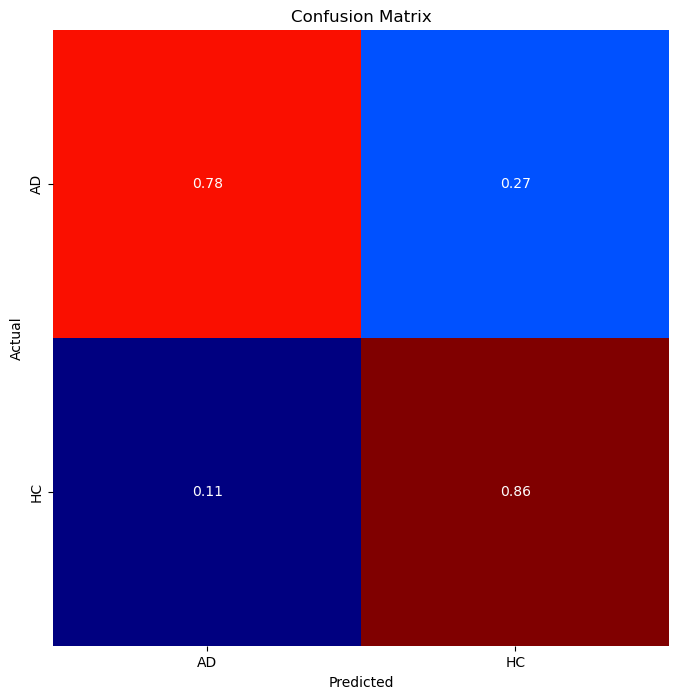

              precision    recall  f1-score   support

           0       0.87      0.78      0.82       114
           1       0.76      0.86      0.81        94

    accuracy                           0.82       208
   macro avg       0.82      0.82      0.82       208
weighted avg       0.82      0.82      0.82       208



# Average matrices

In [434]:
hc_idx = list(np.where(df_usampling["Condition"] == "HC")[0])
ad_idx = list(np.where(df_usampling["Condition"] == "AD")[0])

In [435]:
corr_hc = np.zeros((20,20))
corr_ad = np.zeros((20,20))

In [436]:
for i in hc_idx: 
    corr_hc += X[i]
corr_hc = corr_hc/len(hc_idx)
for i in ad_idx: 
    corr_ad += X[i]

corr_ad = corr_ad/len(ad_idx)

<AxesSubplot:>

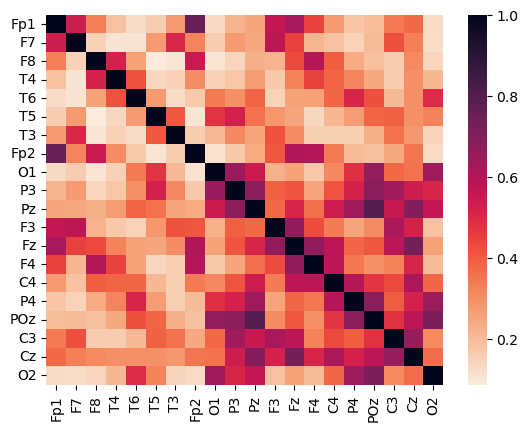

In [445]:
cmap = sns.cm.rocket_r

sns.heatmap(corr_hc**2, cmap=cmap, vmax=1, xticklabels=channels, yticklabels=channels)

<AxesSubplot:>

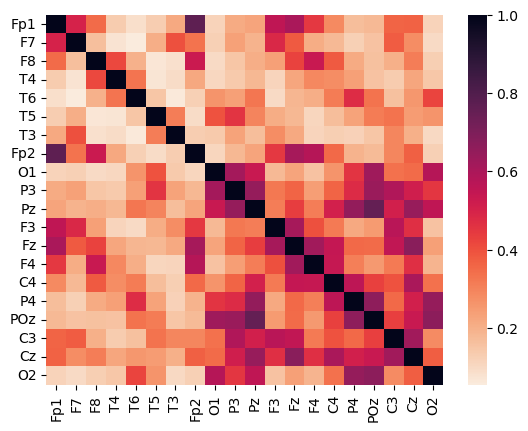

In [446]:
sns.heatmap(corr_ad**2, cmap=cmap, vmax=1, xticklabels=channels, yticklabels=channels)

<AxesSubplot:>

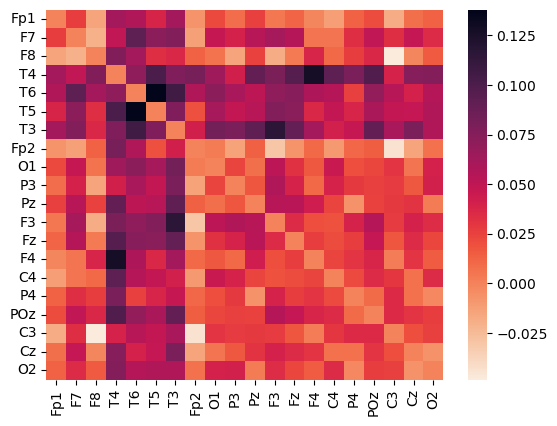

In [448]:
sns.heatmap((corr_hc-corr_ad), cmap=cmap, xticklabels=channels, yticklabels=channels)